In [94]:
import os
from pathlib import Path
import json
import pandas as pd
import numpy as np
from plotnine import *
from functools import reduce
from scipy import stats

In [95]:
options_dir = Path('data/workload_options')

values = [1, 2, 10]
prefix = 'constant-'
prefix = 'bursty-'
prefix = 'spikes-'
postfix = ''
postfix = '-compound'

def read_options(file_name):
    options_path = options_dir / file_name

    with open(options_path) as json_file:
        workload_options = json.load(json_file)
        stages = workload_options['scenarios']['benchmark_scenario']['stages']
        return pd.DataFrame.from_dict(stages, orient='columns')

def convert_options(workload_df, name):
    rows = []
    time = 0
    for duration, target in zip(workload_df['duration'], workload_df['target']):
        num_seconds = int(duration.split('s')[0])
        for _ in range(num_seconds):
            rows.append([time, target])
            time += 1
    # Create df from list
    workload_res = pd.DataFrame(rows, columns=['relative_time', name])
    return workload_res[['relative_time', name]]

data_frames = []
names = []
for v in values:
    file_name = f"{prefix}{v}{postfix}.json"
    names.append(file_name)
    df_in = read_options(file_name)
    df_out = convert_options(df_in, file_name)
    data_frames.append(df_out)

df_merged = reduce(lambda  left,right: pd.merge(left,right,on=['relative_time'], how='outer'), data_frames)
# df_merged.head(10)

# df_long = pd.wide_to_long(df_merged, ['A'], i='relative_time', j="type")
df_long = pd.melt(df_merged, id_vars='relative_time', value_vars=names, var_name='workload_type', value_name='invocations_per_second')
# df_long.head(10)

df_long.groupby("workload_type").agg({
    "invocations_per_second": ["count", "min", "max", "median", "mean", "sum"],
})


invocations_per_second                            \
                                         count min max median       mean   
workload_type                                                              
spikes-1-compound.json                    1200   0   6      0   1.516667   
spikes-10-compound.json                   1200   0  60      0  10.642500   
spikes-2-compound.json                    1200   0  12      0   2.621667   

                                
                           sum  
workload_type                   
spikes-1-compound.json    1820  
spikes-10-compound.json  12771  
spikes-2-compound.json    3146

/Users/joe/.virtualenvs/explore_sb_logs/lib/python3.8/site-packages/plotnine/ggplot.py:719: PlotnineWarning: Saving 8 x 5 in image.
/Users/joe/.virtualenvs/explore_sb_logs/lib/python3.8/site-packages/plotnine/ggplot.py:722: PlotnineWarning: Filename: data/workload_options/spikes--compound.png


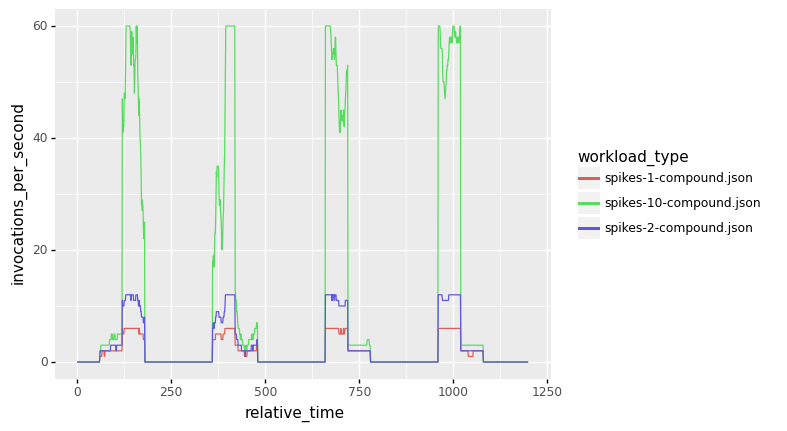

<ggplot: (301981666)>

In [96]:
# Comparison plot
p = (
    ggplot(df_long)
    + aes(x='relative_time', y='invocations_per_second', color='workload_type')
    + geom_line()
    # Minute separators
    # + geom_vline(xintercept=range(0, 1250, 60), color='lightgrey')
)
dest = options_dir / f"{prefix}{postfix}.png"
p.save(filename = dest, height=5, width=8, units = 'in', dpi=200)
p